# Simple Compressed Sensing Example

A complete compressed sensing demonstration in one cell.

Compressed Sensing: 256 → 128 samples (2.0:1 compression)
Relative reconstruction error: 0.0000 (0.00%)


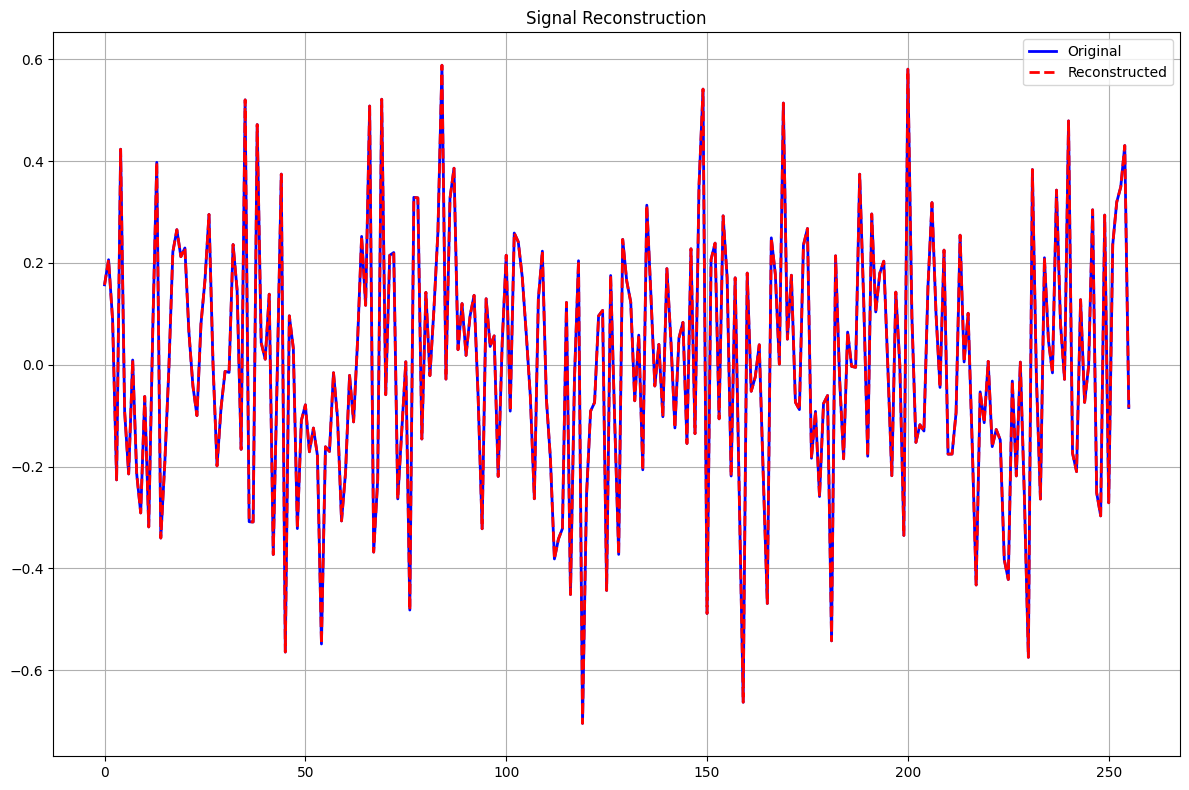


✓ Compressed sensing completed successfully!
✓ Compressed 256 samples to 128 measurements
✓ Recovered signal with 0.00% error
✓ Time taken: 0.01 seconds


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
from sklearn.linear_model import OrthogonalMatchingPursuit
import time

# Parameters
N = 256  # Signal length
M = 128   # Number of measurements (4:1 compression)
K = 20   # Sparsity level

print(f"Compressed Sensing: {N} → {M} samples ({N/M}:1 compression)")

# 1. Create sparse signal in DCT domain
np.random.seed(42)
x_sparse = np.zeros(N)
sparse_indices = np.random.choice(N, K, replace=False)
x_sparse[sparse_indices] = np.random.randn(K)
x_original = idct(x_sparse, norm='ortho')  # Transform to time domain

# 2. Create sensing matrix (random Gaussian)
Phi = np.random.randn(M, N) / np.sqrt(M)

# 3. Create sparsifying basis (DCT matrix)
Psi = idct(np.eye(N), norm='ortho', axis=0)

start = time.time()

# 4. Compressed sensing matrix A = Phi * Psi
A = Phi @ Psi

# 5. Take measurements
y = Phi @ x_original

# 6. Reconstruct using Orthogonal Matching Pursuit
omp = OrthogonalMatchingPursuit(n_nonzero_coefs=K)
omp.fit(A, y)
x_sparse_recovered = omp.coef_

# 7. Transform back to time domain
x_recovered = Psi @ x_sparse_recovered
elapsed = time.time() - start
# 8. Calculate error
error = np.linalg.norm(x_original - x_recovered) / np.linalg.norm(x_original)
print(f"Relative reconstruction error: {error:.4f} ({error*100:.2f}%)")

# 9. Plot results
fig, axes = plt.subplots(figsize=(12, 8))

# Original vs Reconstructed
axes.plot(x_original, 'b-', label='Original', linewidth=2)
axes.plot(x_recovered, 'r--', label='Reconstructed', linewidth=2)
axes.set_title('Signal Reconstruction')
axes.legend()
axes.grid(True)

plt.tight_layout()
plt.show()

print("\n✓ Compressed sensing completed successfully!")
print(f"✓ Compressed {N} samples to {M} measurements")
print(f"✓ Recovered signal with {error*100:.2f}% error")
print(f"✓ Time taken: {elapsed:.2f} seconds")

In [1]:
import math
import cr.nimble as crn
import cr.sparse as crs
import cr.sparse.dict as crdict
import cr.sparse.data as crdata
import cr.sparse.lop as crlop
import cr.sparse.plots as crplots
import numpy as np
import jax
import jax.numpy as jnp
import cr.sparse.lop as crlop
from jax import random
from eeg_cs.models.loader import CHBMITLoader

# Metadata
key = random.PRNGKey(42)
keys = random.split(key, 3)

random_state = 50
loader = CHBMITLoader()

fileName = "chb09_13.edf"
start_time_idx = 1198080
segment_length_s = 4
downsampled_fs = 128
ch_name = "P4-O2"
x = loader.get_signal(
  fileName, start_time_idx, segment_length_s, downsampled_fs, ch_name
)
N = loader.get_downsampled_n_samples(segment_length_s, downsampled_fs)
CR = 2
M = N // CR

# Signal generation
k = 80
x, omega = crdata.sparse_normal_representations(keys[2], N, k)
x = Psi.times(x)

ax = crplots.one_plot()
crplots.plot_signal(ax, x)

/home/jplp/Disco X/UFMG/2025/TCC/Códigos/eeg_cs/eeg_cs/models/loader.py:281: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, include=self.ch_names, verbose=False)


NameError: name 'Psi' is not defined

In [55]:
from eeg_cs.models.sensing_matrix import BinaryPermutedBlockDiagonal
from cr.sparse import lop

# Create sensing operator
d = 8
# crlop.gaussian_dict(keys[1], M, N)
# Phi = crlop.gaussian_dict(keys[1], M, N, normalize_atoms=True)
Phi = crlop.sparse_binary_dict(keys[1], M, N, d, normalize_atoms=False)
# Create normalized sensing operator
d_scale = 1/ math.sqrt(d)
# d_scale = 1/ math.sqrt(N)
Phi_scale = crlop.scalar_mult(d_scale, M)
Phi_normalized = crlop.compose(Phi_scale, Phi)
# Phi_normalized = Phi

# Phi = lop.matrix(BinaryPermutedBlockDiagonal(M, CR).value)
# d_scale = 1 / BinaryPermutedBlockDiagonal(M, CR).value.sum()
# Phi_scale = crlop.scalar_mult(d_scale, M)
# Phi_normalized = crlop.compose(Phi_scale, Phi)

In [2]:
from eeg_cs.models.sensing_matrix import BinaryPermutedBlockDiagonal

N = loader.get_downsampled_n_samples(segment_length_s, downsampled_fs)
CR = 2
M = N // CR
sensing_matrix = BinaryPermutedBlockDiagonal(M, CR)
Phi = sensing_matrix.value
N = Phi.shape[1]
# 1) normalize each row of Phi
Phi_norms = np.linalg.norm(Phi, axis=1, keepdims=True)
Phi_norms[Phi_norms == 0] = 1.0  # Prevent division by zero
Phi_normed = Phi / Phi_norms
# 3) form the matrix of all inner products
G = Phi_normed @ Phi_normed
# 4) take maximum absolute entry and scale
np.sqrt(N) * np.max(np.abs(G))

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 256 is different from 512)

In [56]:
# Create dictionary
# Psi = crlop.dwt(N, wavelet='db8', level=4, basis=True)
Psi = crlop.cosine_basis(N)
Psi = crlop.jit(Psi)

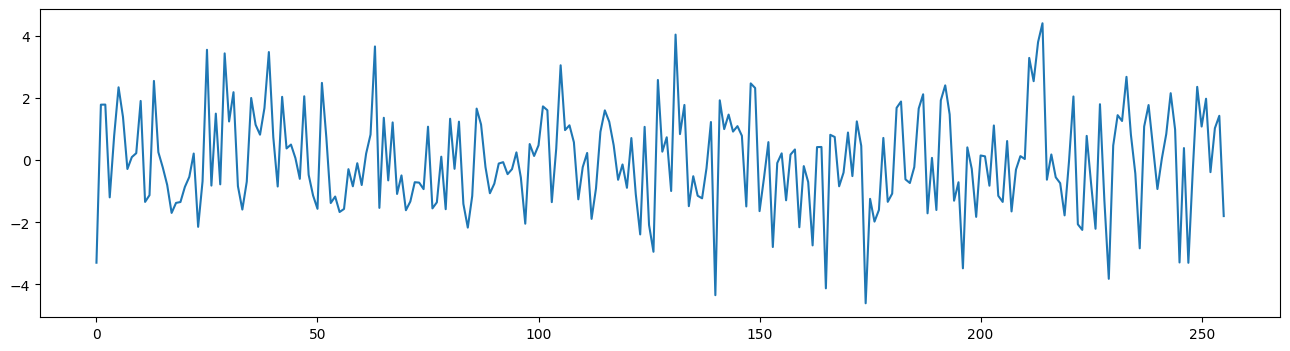

In [57]:
# Take measurements
y = Phi.times(x)
ax = crplots.one_plot()
crplots.plot_signal(ax, y)

In [67]:
import cr.sparse.cvx.spgl1 as crspgl1
from cr.sparse.pursuit import cosamp
import cr.sparse.block.bsbl as bsbl

# Theta = Phi_normalized.times(Psi)
Theta = crlop.compose(Phi_normalized, Psi)
# Theta = crlop.compose(Phi, Psi)

# # Solve the problem
# k = 175
# sol =  cosamp.operator_solve_jit(Theta, y, k)
# print(sol)

# sigma = 0.00001 * jnp.linalg.norm(y)
# options = crspgl1.SPGL1Options(max_iters=10000)
# sol = crspgl1.solve_bpic_jit(Theta, y, sigma, options)

Theta = lop.to_matrix(Theta)
options = bsbl.bsbl_bo_options(y, learn_lambda=0)
sol = bsbl.bsbl_bo_jit(Theta, y, 8, options)

# We need to scale the solution since the measurements were unscaled
# x_hat = Psi.times(sol.x)
x_hat = Psi.times(sol.x * d_scale)

SNR: 1.42 dB, PRD: 84.94598388671875 %


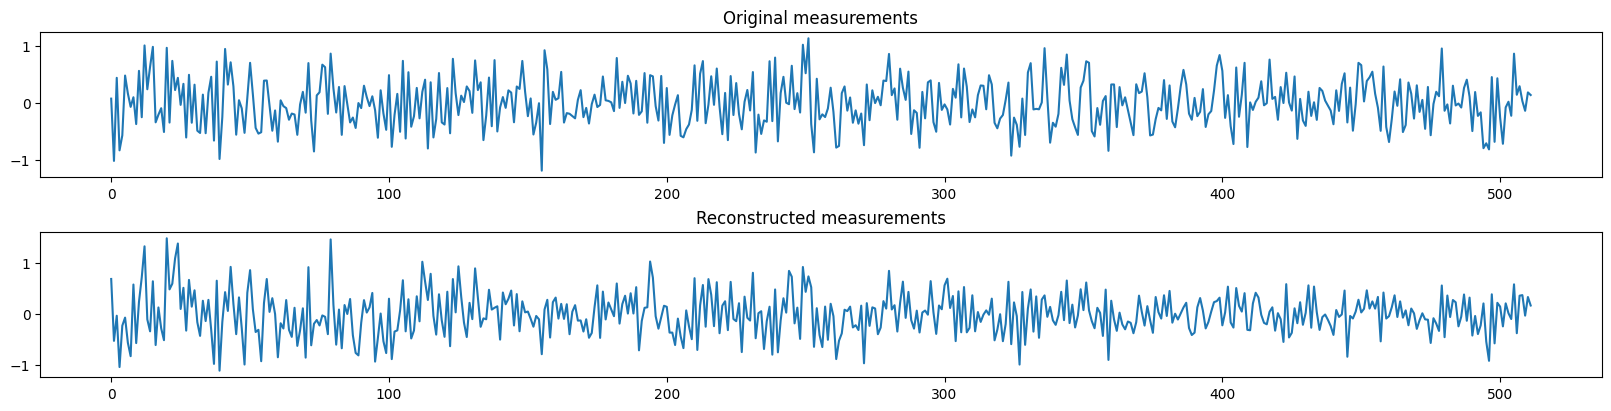

In [68]:
# Compute the SNR and PRD
print(f'SNR: {crn.signal_noise_ratio(x, x_hat):.2f} dB, PRD: {crn.percent_rms_diff(x, x_hat)} %')

def plot_measurments(b0, b):
    ax = crplots.h_plots(2, height=2)
    ax[0].plot(b0)
    ax[0].set_title('Original measurements')
    ax[1].plot(b)
    ax[1].set_title('Reconstructed measurements')

# Plot the original and the reconstructed signal
plot_measurments(x, x_hat)